# Segmenting and Clustering Neighborhoods in Toronto

## import same libraries as lab

In [39]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# install beautiful soup for easier parsing of web data
!pip install beautifulsoup4

from bs4 import BeautifulSoup 

print('Libraries imported.')

Libraries imported.


## scrape wikipedia data

### load data from wikipedia, store into pandas df

In [40]:
data_url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_html = requests.get(data_url).text
soup = BeautifulSoup(raw_html,'html5lib')

dfs = pd.read_html(str(soup.table))
df = dfs[0]
df.head()


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### clean up data

In [41]:
# Drop rows where Borough is Not assigned
df1 = df[df.Borough != 'Not assigned']

# Combine neighborhoods with same Postal Code
df2 = df1.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace = True)

# Replacing the name of the neighborhoods which are Not assigned with names of its Borough instead
df2['Neighbourhood'] = np.where(df2['Neighbourhood'] == 'Not assigned', df2['Borough'], df2['Neighbourhood'])

df2.head(12)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


### number of rows in this dataframe

In [43]:
df2.shape

(103, 3)

## Include Geographic (lat/long) Data

In [47]:
# read the csv
geospatial_data = pd.read_csv('https://cocl.us/Geospatial_data')

# join up the dataframes 
df3 = pd.merge(df2, geospatial_data, on = 'Postal Code')
df3.head(12)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Clustering the toronto neighborhoods

In [60]:
# get just toronto neighborhoods in own df
df4 = df3[df3['Borough'].str.contains('Toronto', regex = False)]

In [61]:
# generate 5 clusters based off of lat/long
k = 5

# drop non lat/long data
toronto_clustering = df4.drop(['Postal Code','Borough','Neighbourhood'],1)

# do k means
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans.labels_
df4.insert(0, 'Cluster Labels', kmeans.labels_)

In [62]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df4['Latitude'], df4['Longitude'], df4['Neighbourhood'], df4['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### map screenshot since it won't load in github
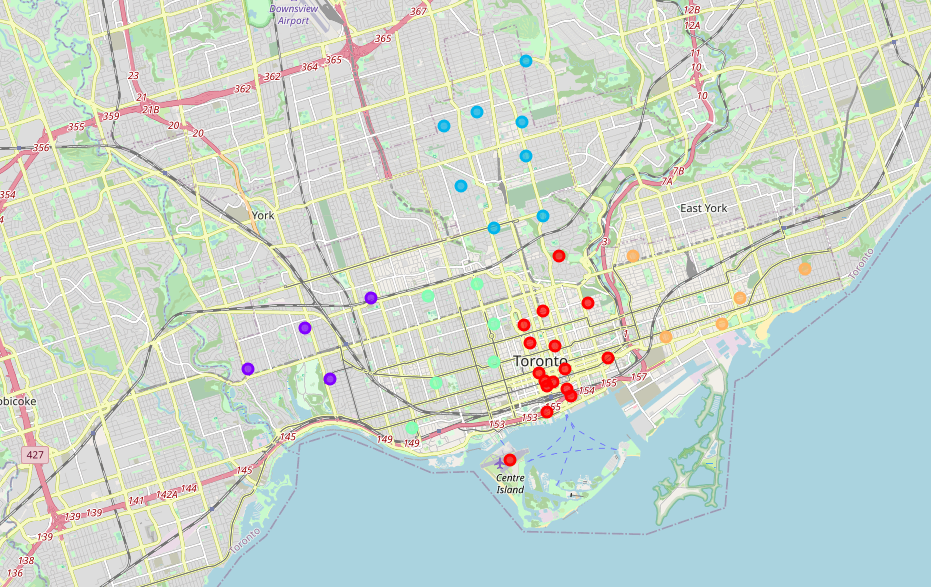